### Heart Disease

Data 04-04-2020

https://www.kaggle.com/ronitf/heart-disease-uci

In [2]:
from pandas import read_csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc


In [3]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

In [6]:
from sklearn.metrics import confusion_matrix,accuracy_score, auc
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import plot_confusion_matrix

In [7]:
df = pd.read_csv('heart.csv')

In [8]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [9]:
print('A base consiste em ' + str(df.shape[0]) + ' e ' + str(df.shape[1]) + ' colunas')

A base consiste em 303 e 14 colunas


### Numero de NaN's

In [10]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

### Balanceamento das classes

In [11]:
print('Proporção da classe 1: ',round(np.bincount(df.target)[1]/(np.bincount(df.target)[0]+np.bincount(df.target)[1]),2))

Proporção da classe 1:  0.54


Segundo "Applied Predictive Modeling", temos um problema de aprendizado desbalanceado quando uma das classes possui uma proporção muito baixa. Neste contexto, admitindo que 54 % para a classe 1 e
46% para a classe 0 não constitui proporções muito baixas, podemos concluir que não estamos tratando de um problema desbalanceado.

# Modelos

Usaremos o método de cross validation e a métrica de acurácia para selecionar o melhor modelo de classificação entre:

- Regressão Logística
- k-Nearest Neighbors
- Decision Trees
- Random Forest
- Support Vector Machine


### Treino e Test

In [12]:
X_train, X_test, y_train, y_test= train_test_split(df.iloc[:, :-1],df.iloc[:,-1],   
                                                                        test_size=0.3, random_state=147,stratify=df.iloc[:,-1])

A opção stratify faz com que a divisão seja de tal forma que a proporção da classe 1 seja mantida igual nas duas divisões.

### Normalização de dados

Faremos a normalização dos dados através da funcão $x\rightarrow \frac{x-\overline{x}}{\sigma(x)}$:

In [13]:
scalar = StandardScaler()

In [14]:
# Parãmetros do K-fold: Utilizaremos 10 k-folds
kfold = KFold(n_splits=15)

### Regressão Logistica

In [15]:

model = LogisticRegression()

pipeline = Pipeline([('transformer', scalar), ('estimator', model)])

results_rg = cross_val_score(pipeline, X_train, y_train, cv=kfold)
print("Accuracy: %.3f%% ( std %.3f%%)" % (results_rg.mean()*100.0, (results_rg.std()*100.0)))

Accuracy: 79.683% ( std 11.363%)


### K-nearest neighborhood - Knn

In [16]:
model = KNeighborsClassifier()
pipeline = Pipeline([('transformer', scalar), ('estimator', model)])
results_knn = cross_val_score(pipeline, X_train, y_train, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results_knn.mean()*100.0, (results_knn.std()*100.0)))

Accuracy: 79.651% (9.798%)


### Árvores de decisão

In [17]:
model = DecisionTreeClassifier()
pipeline = Pipeline([('transformer', scalar), ('estimator', model)])
results_ad = cross_val_score(pipeline, X_train, y_train, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results_ad.mean()*100.0, (results_ad.std()*100.0)))

Accuracy: 72.127% (13.408%)


### Randon Forest

In [18]:
model = RandomForestClassifier()
pipeline = Pipeline([('transformer', scalar), ('estimator', model)])
results_rf = cross_val_score(pipeline, X_train, y_train, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results_rf.mean()*100.0, (results_rf.std()*100.0)))

Accuracy: 81.079% (10.011%)


In [19]:
### Comparação dos métodos

In [20]:
results = pd.DataFrame()
results['LR'] = results_rg
results['KNN'] = results_knn
results['AD'] = results_ad
results['RF'] = results_rf

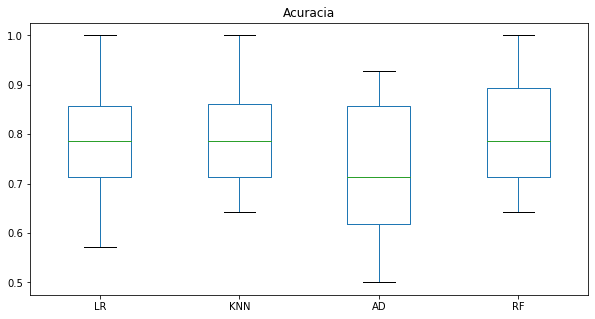

In [21]:
plt.figure(figsize=(10,5))
results.boxplot(grid=False)
plt.title('Acuracia')
plt.show()

Com base no gráfico de box-plot acima, escolhemos o modelo Random Forest

## Ajustando o modelo Random Forest

Ajustaremos os seguintes parâmetros do Random Forest:

- n_estimators : Número de arvóres
- max_depth    : máxima profundidade de cada árvore
- min_samples_split : O menor número de amostrar requeridas para a obtenção do split de um  node

Para outros parâmetros:
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


Para o ajuste, utilizaremos o Random Search.

In [22]:
model = RandomForestClassifier()

In [23]:
distributions = dict(n_estimators=np.arange(2,10),max_depth =np.arange(2,10),min_samples_split=np.arange(2,10))

In [24]:
clf = RandomizedSearchCV(model, distributions, random_state=0, scoring='accuracy')

In [25]:
search = clf.fit(X_train, y_train)

In [26]:
param_best = search.best_params_
print(param_best)

{'n_estimators': 8, 'min_samples_split': 7, 'max_depth': 2}


In [27]:
n_estimators = param_best['n_estimators']
min_samples_split = param_best['min_samples_split']
max_depth = param_best['max_depth']

Vamos agora fitar o modelo com os dados obtidos do Random Search

In [28]:
model_final = RandomForestClassifier(n_estimators = n_estimators,min_samples_split= min_samples_split, max_depth=max_depth )
model_final.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=8,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Observemos que não aplicamos normalização dos dados. Isso não se fez necessário no caso de Random Forest (ou qualquer algoritmo de árvores)

## Avaliação do Modelo

### Acuracia do modelo no conjunto de test

In [29]:
predict_y = model_final.predict(X_test)

In [193]:
print('Acurácia do modelo nos dados de teste', round(accuracy_score(y_test, predict_y),2))

Acurácia do modelo nos dados de teste 0.86


### Matrix de Confusão

In [30]:
# funcao para a construcao da matriz de confusao
def Confusion_matrix(model, X_test,Y_test, normalized = True):
    if normalized==True:
        disp = plot_confusion_matrix(model, X_test, Y_test,
                                 display_labels=['Negative_covid', 'Positive_covid'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
        disp.ax_.set_title('Normalized confusion matrix')
    else:
        disp = plot_confusion_matrix(model, X_test, Y_test,
                                 display_labels=['Negative_covid', 'Positive_covid'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
        disp.ax_.set_title('Confusion matrix')
    plt.show()

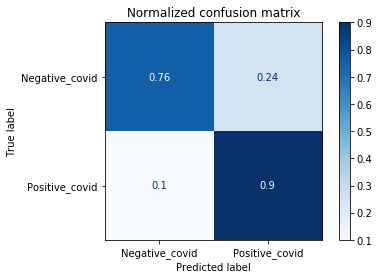

In [32]:
Confusion_matrix(model_final, X_test,y_test, normalized = True)

- Precision = True Positives / (True Positives + False Positives)
  
- Recall = Sensitivity = = True Positives / (True Positives + False Negatives)

- Specificity = True Negatives / (True Negatives + False Positives)

In [36]:
1/(1+0.1)

0.9090909090909091

Observamos que a Sensibilidade do modelo é de 0.9, o que indica que o modelo fornece poucos falso negativos
(Portadores de doenças que o modelo diz que não possui)

In [33]:
# funcao para plot dos resultados: curvas de aprendizado e precision e recall
def Chart_report(model, X_test,Y_test):
    predict_y = model.predict(X_test)
    
    plt.figure(figsize=(20,10))
    
    # Confusion, ROC
    plt.subplot(1,2,1)
        
    prob_y = model.predict_proba(X_test)[:,1]
    fpr, tpr,_ = roc_curve(Y_test, prob_y)
    auc_value = auc(fpr, tpr)
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    # axis labels

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.text(0.8, 0.05, 'AUC ' + str(round(auc_value,3)))
    # show the legend
    #plt.legend()
    plt.title('ROC')    
    
    # Precision X Recall
    
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
    yhat = model.predict(X_test)
    lr_precision, lr_recall, th = precision_recall_curve(Y_test, lr_probs)
    th = np.append(th,[1])
    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.subplot(1,2,2)
    plt.plot(th, lr_recall, marker='.', label='Recall')
    plt.plot(th, lr_precision, marker='.', label='Precision')
    # axis labels
    plt.xlabel('threshold')
    plt.ylabel('Valor')
    plt.title('Precision and Recall')
    # show the legend
    plt.legend()
    # show the plot
    
    
    
    plt.show()

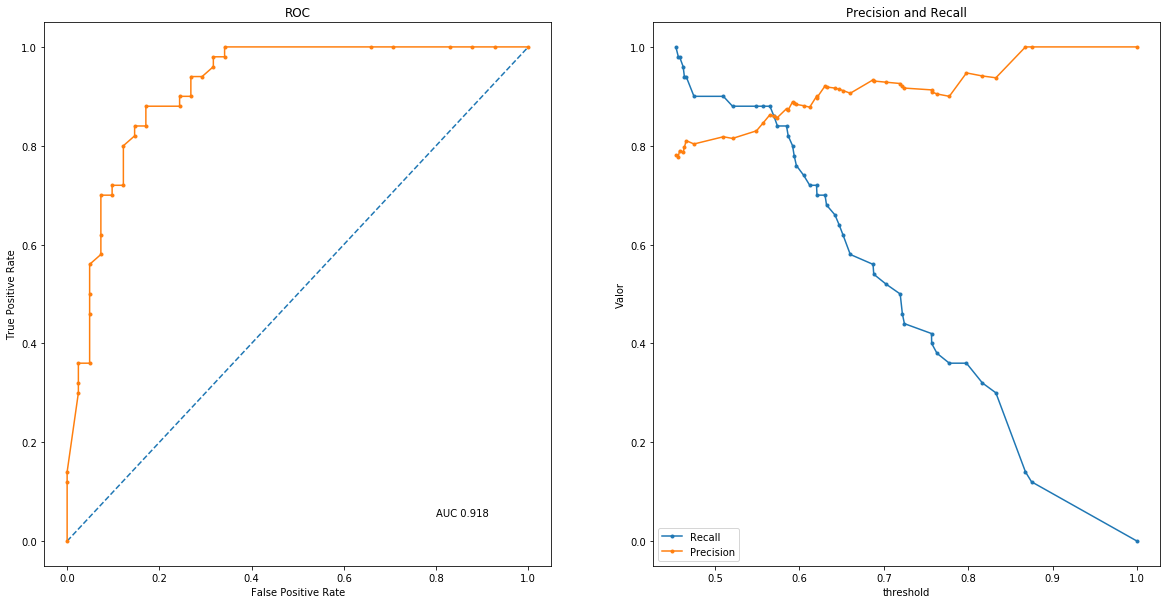

In [34]:
Chart_report(model_final, X_test,y_test)